In [2]:
import numpy as np
from cellpose import models, io
from skimage import io as skio, measure
from os.path import join, basename
import os
from pathlib import Path
from tqdm.notebook import tqdm 
import warnings


img_dir = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2\Individual_cropped_traps_directory\Cropped_traps_position_5"
labels_dir = Path(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2\Unique_masks_directory")
labels_dir.mkdir(exist_ok=True)

### Run Cellpose and save masks

In [8]:
import numpy as np
from cellpose import models, io
from skimage import io as skio, measure
from os.path import join, basename
import os
from pathlib import Path
from tqdm.notebook import tqdm 
import warnings


# List all files in the input directory
files = [f for f in os.listdir(img_dir) if f.endswith('.tiff')]

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto2')

# or if you have different types of channels in each image
channels = [[0, 0]]

# Set custom parameters
custom_params = {
    'diameter': 60.0,
    'interp': 'lanczos3',
    'cellprob_threshold': 0.1,
    'flow_threshold': 0.4,
    'min_size': 30
}

for img_file in tqdm(list(Path(img_dir).iterdir()), desc="Processing images"):
    # Read the image
    img = io.imread(img_file)

    # Perform cell segmentation
    masks, _, _, _ = model.eval(img, channels=channels, **custom_params)

    # Save unique cell labels as numpy array TIFF file
    labels = measure.label(masks)

    # Save the unique mask with a specific filename in the labels_dir
    labels_file = labels_dir / f"{img_file.stem}.tiff"
    skio.imsave(labels_file, labels.astype(np.uint16), plugin='tifffile')

# To ignore all warnings
warnings.filterwarnings("ignore")

Processing images:   0%|          | 0/392 [00:00<?, ?it/s]

C:\Users\micha\AppData\Local\Temp\ipykernel_14168\2127527688.py:40: UserWarning: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2\Unique_masks_directory\original_frame_100_cropped_trap_pos_5.tiff is a low contrast image
  skio.imsave(labels_file, labels.astype(np.uint16), plugin='tifffile')
C:\Users\micha\AppData\Local\Temp\ipykernel_14168\2127527688.py:40: UserWarning: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2\Unique_masks_directory\original_frame_101_cropped_trap_pos_5.tiff is a low contrast image
  skio.imsave(labels_file, labels.astype(np.uint16), plugin='tifffile')
C:\Users\micha\AppData\Local\Temp\ipykernel_14168\2127527688.py:40: UserWarning: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2\Unique_masks_directory\original_frame_102_cropped_trap_pos_5.tiff is a low contrast image
  skio.imsave(labels_file, labels.astype(np.uint16), plugin='

### View labels and traps in Napari

In [29]:
import napari
from skimage import io as skio, measure, segmentation
from pathlib import Path
import numpy as np
import os
from natsort import natsorted  # Ensure you have the natsort library installed: pip install natsort
import warnings

# Extract the numeric part from the filenames using a custom key function
key_function = lambda x: int(''.join(filter(str.isdigit, x)))

# Get a sorted list of file paths
img_paths = natsorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.tiff')], key=key_function)
labels_paths = natsorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.tiff')], key=key_function)

# Read the images
original_images = [skio.imread(img_path) for img_path in img_paths]
unique_labels = [skio.imread(labels_path) for labels_path in labels_paths]

# Set thresholds for minimum and maximum area, maximum eccentricity, and minimum circularity
min_area_threshold = 100
max_area_threshold = 10000  # Adjust as needed
max_eccentricity_threshold = 0.7 # Adjust as needed
min_circularity_threshold = 0.75 # Adjust as needed

# Filter labels based on area, eccentricity, and circularity thresholds
filtered_labels = []
for labels in unique_labels:
    filtered_labels_no_border = segmentation.clear_border(labels)
    props = measure.regionprops(filtered_labels_no_border)

    filtered_label = np.zeros_like(labels)
    for prop in props:
        circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0

        if (
            min_area_threshold <= prop.area <= max_area_threshold and
            prop.eccentricity <= max_eccentricity_threshold and
            circularity >= min_circularity_threshold
        ):
            filtered_label[prop.coords[:, 0], prop.coords[:, 1]] = prop.label
    
    filtered_labels.append(filtered_label)

# Open Napari viewer
viewer = napari.Viewer()

# Stack images horizontally
stacked_images = np.hstack(original_images)
viewer.add_image(stacked_images, name='Stacked Original Images', colormap='gray')

# Stack filtered masks horizontally
stacked_filtered_labels = np.hstack(filtered_labels)
viewer.add_labels(stacked_filtered_labels, name='Stacked Filtered Cell Labels')

# Start the Napari viewer
napari.run()



NameError: name 'cropped_traps_output_dir' is not defined

### Region props for each image

In [8]:
for i, filtered_label in enumerate(filtered_labels):
    print(f"Image {i + 1}:")

    # Measure region properties for the current filtered label mask
    props_region = measure.regionprops(filtered_label)

    # Print label, area, and equivalent diameter for each region in the filtered label mask
    for prop in props_region:
        print(f"Label: {prop.label}, Area: {prop.area}, Equivalent Diameter: {prop.equivalent_diameter}")


Image 1:
Label: 2, Area: 5352.0, Equivalent Diameter: 82.54924617113467
Image 2:
Label: 2, Area: 5635.0, Equivalent Diameter: 84.70362940619866
Image 3:
Label: 2, Area: 5557.0, Equivalent Diameter: 84.11535026434413
Image 4:
Label: 2, Area: 5456.0, Equivalent Diameter: 83.3474352099394
Image 5:
Label: 2, Area: 5476.0, Equivalent Diameter: 83.50005836506793
Image 6:
Label: 2, Area: 5531.0, Equivalent Diameter: 83.9183407958605
Image 7:
Label: 2, Area: 5571.0, Equivalent Diameter: 84.22124140452686
Image 8:
Label: 2, Area: 5669.0, Equivalent Diameter: 84.95878400203028
Image 9:
Label: 2, Area: 5706.0, Equivalent Diameter: 85.23558436626594
Image 10:
Label: 2, Area: 5784.0, Equivalent Diameter: 85.81618452686055
Image 11:
Label: 2, Area: 5670.0, Equivalent Diameter: 84.96627694943666
Label: 15, Area: 9991.0, Equivalent Diameter: 112.78712821704882
Image 12:
Label: 2, Area: 5814.0, Equivalent Diameter: 86.0384490393117
Image 13:
Label: 2, Area: 5849.0, Equivalent Diameter: 86.2970341156401

### Plotting

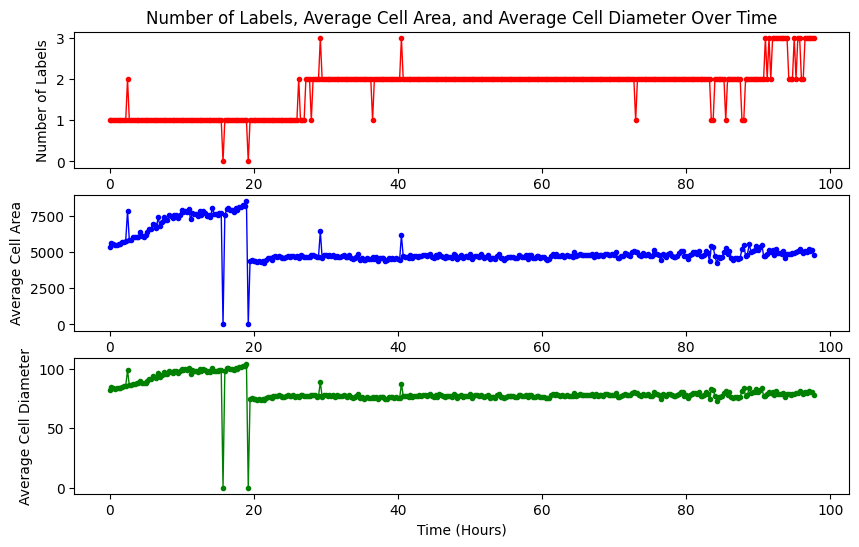

In [12]:
import matplotlib.pyplot as plt

# Time interval between frames (in minutes)
time_interval = 0.25

# Lists to store data for each frame
num_labels_list = []
avg_area_list = []
avg_diameter_list = []

for i, filtered_label in enumerate(filtered_labels):  
    # Measure region properties for the current filtered label mask
    props_region = measure.regionprops(filtered_label)
    
    # Calculate the number of labels
    num_labels = len(props_region)
    num_labels_list.append(num_labels)

    # Calculate average cell area and diameter
    total_area = sum(prop.area for prop in props_region)
    avg_area = total_area / num_labels if num_labels > 0 else 0
    avg_area_list.append(avg_area)

    total_diameter = sum(prop.equivalent_diameter for prop in props_region)
    avg_diameter = total_diameter / num_labels if num_labels > 0 else 0
    avg_diameter_list.append(avg_diameter)

# Calculate time points for each frame based on the time interval
time_points = [i * time_interval for i in range(len(filtered_labels))]

# Plotting
plt.figure(figsize=(10, 6))

# Plot Number of Labels
plt.subplot(3, 1, 1)
plt.plot(time_points, num_labels_list, marker='o', linestyle='-', markersize=3, linewidth=1, color='red')
plt.ylabel('Number of Labels')
plt.title('Number of Labels, Average Cell Area, and Average Cell Diameter Over Time')

# Plot Average Cell Area
plt.subplot(3, 1, 2)
plt.plot(time_points, avg_area_list, marker='o', linestyle='-', markersize=3, linewidth=1, color='blue')
plt.ylabel('Average Cell Area')

# Plot Average Cell Diameter
plt.subplot(3, 1, 3)
plt.plot(time_points, avg_diameter_list, marker='o', linestyle='-', markersize=3, linewidth=1, color='green')
plt.xlabel('Time (Hours)')
plt.ylabel('Average Cell Diameter')

plt.show()


### Tracking

In [28]:
import pandas as pd
import trackpy as tp
import napari

# Initialize an empty DataFrame
df_list = []

for i, filtered_label in enumerate(filtered_labels):
    # Use the filtered labels directly
    props_region = measure.regionprops(filtered_label)

    # Create a DataFrame for the current image
    df_image = pd.DataFrame({
        'Cell_ID': [f"Cell_{i + 1}_{j}" for j in range(1, len(props_region) + 1)],
        'Area': [prop.area for prop in props_region],
        'Equivalent_Diameter': [prop.equivalent_diameter for prop in props_region],
        'x': [prop.centroid[1] for prop in props_region],
        'y': [prop.centroid[0] for prop in props_region],
        'frame': i + 1,
        # Add more columns as needed
    })

    # Append the DataFrame for the current image to the list
    df_list.append(df_image)

# Concatenate DataFrames for all images into a single DataFrame
result_df = pd.concat(df_list, ignore_index=True)

# Use trackpy to link the cells across frames based on centroid positions
tracks = tp.link_df(result_df, search_range=10, memory=3, pos_columns=['x', 'y'])

print(result_df)

# Visualize tracking over original images using napari
viewer = napari.Viewer()

# Stack original images horizontally
stacked_images = np.hstack(original_images)
viewer.add_image(stacked_images, name='Stacked Original Images', colormap='gray')

# Create a tracks layer with scatter points
tracks_layer = viewer.add_points(
    tracks[['x', 'y']].values, 
    size=5, 
    edge_color='red',
    face_color='red',
    symbol='o',
    name='Cell Tracks'
)

# Start the Napari viewer
napari.run()


Frame 392: 3 trajectories present.
        Cell_ID    Area  Equivalent_Diameter          x            y  frame
0      Cell_1_1  5352.0            82.549246  94.394993   373.709081      1
1      Cell_2_1  5635.0            84.703629  93.459982   372.483052      2
2      Cell_3_1  5557.0            84.115350  93.764081   372.636315      3
3      Cell_4_1  5456.0            83.347435  93.742852   369.412023      4
4      Cell_5_1  5476.0            83.500058  95.051680   370.122535      5
..          ...     ...                  ...        ...          ...    ...
684  Cell_391_2  5522.0            83.850037  46.176566   262.595980    391
685  Cell_391_3  4557.0            76.171862  89.408383  1349.736888    391
686  Cell_392_1  4543.0            76.054765  87.882016   190.799472    392
687  Cell_392_2  5333.0            82.402588  46.403150   262.399400    392
688  Cell_392_3  4448.0            75.255362  90.575989  1347.763939    392

[689 rows x 6 columns]


C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (1731, 72912) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (1731, 72912) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (1731, 72912) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (1731, 72912) exceeds GL_MAX_TEXTU